In [42]:
import scipy.io as sio
import os
import numpy as np
import pandas as pd
from scipy.signal import spectrogram

from sklearn.model_selection import train_test_split
from scipy import signal
#mat = scipy.io.loadmat('file.mat')

In [43]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
os.getcwd()
os.chdir('/content/drive/My Drive')

In [7]:
#mat = sio.loadmat('/content/drive/My Drive/MTech_Thesis/DENS/Baseling/Baseline_mit123.mat')

In [8]:
#mat

In [9]:
#data = mat.get('eegData')

In [10]:
#data

In [11]:
#data = np.array(data)

In [12]:
#data.shape

In [5]:
_,_, files = next(os.walk('/content/drive/My Drive/MTech_Thesis/DENS/Emotional'))
files_count = len(files)

In [6]:
files

['Joyous_mit003Trial-2Click-1.mat',
 'Afraid_mit003Trial-6Click-2.mat',
 'Angry_mit003Trial-7Click-4.mat',
 'Hate_mit003Trial-7Click-3.mat',
 'Hate_mit003Trial-10Click-6.mat',
 'Alarmed_mit003Trial-9Click-5.mat',
 'Sad_mit003Trial-11Click-7.mat',
 'Amused_mit004Trial-3Click-1.mat',
 'Adventorous_mit004Trial-4Click-3.mat',
 'Excited_mit004Trial-4Click-2.mat',
 'Disgust_mit004Trial-5Click-4.mat',
 'Disgust_mit004Trial-5Click-5.mat',
 'Happy_mit004Trial-8Click-6.mat',
 'Happy_mit004Trial-8Click-7.mat',
 'Taken Aback_mit004Trial-11Click-9.mat',
 'Distress_mit007Trial-3Click-2.mat',
 'Miserable_mit007Trial-2Click-1.mat',
 'Despondent_mit007Trial-4Click-4.mat',
 'Miserable_mit007Trial-4Click-3.mat',
 'Happy_mit007Trial-7Click-6.mat',
 'Hate_mit007Trial-5Click-5.mat',
 'Joyous_mit007Trial-7Click-7.mat',
 'Calm_mit014Trial-1Click-1.mat',
 'Pensive_mit014Trial-1Click-3.mat',
 'Pensive_mit014Trial-1Click-2.mat',
 'Amused_mit014Trial-2Click-4.mat',
 'Excited_mit014Trial-2Click-5.mat',
 'Amused_mi

In [15]:
#len(files)

In [7]:
rating = pd.read_csv('/content/drive/My Drive/MTech_Thesis/DENS/Rating/wholeFrequencyDependentDataWithVADLFR_ReFormattingWholeFrequencyVA - wholeFrequencyDependentDataWithVADLFR_ReFormattingWholeFrequencyVA.csv')

In [17]:
#df = rating[rating["Subject"].str.contains('Dissatisfied_mit114Trial-7Click-19')]

In [18]:
#df = df[['Subject','valence','arousal']]

In [19]:
#df = df.drop_duplicates()

In [20]:
#valence = df['valence']
#arousal = df['arousal']

In [21]:
#print(valence.values[0])
#print(arousal)

In [44]:
eeg_data = []
eeg_label = []

In [45]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence <= 5):
        label = 0 
    elif (valence > 5):
        label = 1
    
    return label

In [46]:
base_path = "/content/drive/My Drive/MTech_Thesis/DENS/Emotional/"
for f in files:
  if f.endswith(".mat"):
    file_str = f[:-4]
    df = rating[rating["Subject"].str.contains(file_str)]
    if not df.empty:
      path = base_path + f
      mat = sio.loadmat(path)
      data = mat.get('eegData')
      eeg_data.append(data)
      df = df[['Subject','valence','arousal']]
      df = df.drop_duplicates()
      valence = df['valence']
      arousal = df['arousal']
      lab = label_mapping(valence.values[0], arousal.values[0])
      eeg_label.append(lab)

In [47]:
eeg_data = np.array(eeg_data)

In [48]:
eeg_data.shape

(465, 128, 1751)

In [49]:
eeg_label = np.array(eeg_label)

In [50]:
eeg_label.shape

(465,)

In [54]:
eeg_Label = []
for i in eeg_label:
    for j in range (0,128):
        eeg_Label.append(i)

In [52]:
eeg_Label = np.array(eeg_Label)
count0 = np.count_nonzero(eeg_Label == 0)
count1 = np.count_nonzero(eeg_Label == 1)

In [53]:
print(count0)
print(count1)

42240
17280


In [55]:
from tensorflow.keras.utils import to_categorical 
y = to_categorical(eeg_Label)

In [56]:
y.shape

(59520, 2)

In [57]:
import functools
def combine_dims(a, i=0, n=1):
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])

In [58]:
eeg_Data = combine_dims(np.array(eeg_data), 0)

In [59]:
eeg_Data.shape

(59520, 1751)

In [70]:
fs = 250

size_dataset = len(eeg_Data)
X_full = np.ndarray(shape=(size_dataset, 63, 26, 3))#Signal spectogram # 128 overlap
X_test_Full = []               
for i in range(0, size_dataset):
  for j in range(0,3):
    X = eeg_Data[i] 
    f, t, Sxx = spectrogram(X, fs, nperseg = 125, noverlap = 62.5, mode='psd')
    X_full[i, :, :, j] = Sxx
    #X_test_Full.append(Sxx)

In [71]:
X_full = np.array(X_full)

In [72]:
X_full.shape

(59520, 63, 26, 3)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=23)

In [74]:
X_train /= 255
X_test /= 255

In [75]:
import pandas as pd
import keras.backend as K
import numpy as np

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, TimeDistributed, RepeatVector
from keras.layers import LSTM, GRU, SimpleRNN
from keras import backend as K
from keras.models import Model
import timeit


#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

import sys
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [76]:
batch_size = 32 
num_classes = 2 
epochs = 100 

In [77]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
input_shape

(63, 26, 3)

In [79]:
zero_weight = 0.70
one_weight = 1.72

In [80]:
model = Sequential()

model.add(Conv2D(32, (3, 3), 
          strides=(1, 1),
          activation='relu', 
          input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), 
          activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(RepeatVector(4))
'''
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
'''
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))


model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 61, 24, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 10, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 5, 64)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 5, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4480)             

In [81]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.005)
model.compile(optimizer ="Adam", loss =keras.losses.categorical_crossentropy,metrics=["accuracy"], weighted_metrics=["accuracy"])

m=model.fit(X_train, y_train,epochs=100,batch_size=32,verbose=1,validation_data=(X_test, y_test),class_weight={0:zero_weight, 1:one_weight})

Epoch 1/100
1302/1302 [==============================] - 16s 10ms/step - loss: 0.6894 - accuracy: 0.5339 - weighted_accuracy: 0.5023 - val_loss: 0.6896 - val_accuracy: 0.7051 - val_weighted_accuracy: 0.7051
Epoch 2/100
1302/1302 [==============================] - 12s 9ms/step - loss: 0.6895 - accuracy: 0.5503 - weighted_accuracy: 0.4952 - val_loss: 0.6910 - val_accuracy: 0.7051 - val_weighted_accuracy: 0.7051
Epoch 3/100
1302/1302 [==============================] - 12s 9ms/step - loss: 0.6892 - accuracy: 0.5814 - weighted_accuracy: 0.5002 - val_loss: 0.6953 - val_accuracy: 0.2953 - val_weighted_accuracy: 0.2953
Epoch 4/100
1302/1302 [==============================] - 12s 9ms/step - loss: 0.6893 - accuracy: 0.4879 - weighted_accuracy: 0.5004 - val_loss: 0.6883 - val_accuracy: 0.7051 - val_weighted_accuracy: 0.7051
Epoch 5/100
1302/1302 [==============================] - 12s 9ms/step - loss: 0.6888 - accuracy: 0.5868 - weighted_accuracy: 0.5009 - val_loss: 0.6900 - val_accuracy: 0.7056 -

In [82]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

558/558 [==============================] - 2s 4ms/step - loss: 0.1785 - accuracy: 0.9693 - weighted_accuracy: 0.9693
Test loss: 0.17850008606910706
Test accuracy: 0.9693100452423096


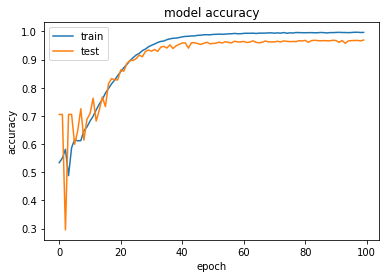

In [83]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

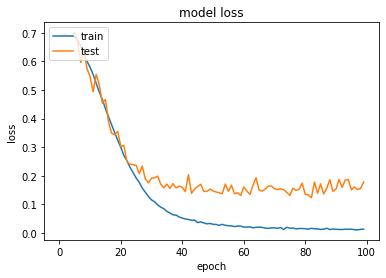

In [84]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()